In [49]:
from matplotlib.pyplot import *

from raysect.primitive import Sphere, Box, Cylinder
from raysect.optical import World, translate, rotate, Point3D, d65_white, ConstantSF
from raysect.optical.observer import PinholeCamera
from raysect.optical.library import Gold, Silver, Copper, Titanium, Aluminium
from raysect.optical.material import Lambert, UniformSurfaceEmitter
from raysect.optical.material.debug import PerfectReflectingSurface

In [50]:
world = World()

# Sphere(0.6, world, transform=translate(1.2, 0.5001, 0.6), material=PerfectReflectingSurface())
# Sphere(0.5, world, transform=translate(0.6, 0.5001, -0.6), material=Silver())
# # Sphere(0.5, world, transform=translate(0, 0.5001, 0.6), material=Copper())
# # Sphere(0.5, world, transform=translate(-0.6, 0.5001, -0.6), material=Titanium())
# # Sphere(0.5, world, transform=translate(-1.2, 0.5001, 0.6), material=Aluminium())

# Box(Point3D(-100, -0.1, -100), Point3D(100, 0, 100), world, material=Lambert(ConstantSF(1.0)))
# Cylinder(3.0, 8.0, world, transform=translate(4, 8, 0) * rotate(90, 0, 0), material=UniformSurfaceEmitter(d65_white, 1.0))

# camera = PinholeCamera((512, 512), parent=world, transform=translate(0, 4, -3.5) * rotate(0, -48, 0))
# camera.spectral_bins = 15
# camera.pixel_samples = 100

# # start ray tracing
# p = 1
# print("Rendering pass {}...".format(p))
# camera.observe()

In [51]:
import trimesh
import numpy as np

# 参数设置
radius = 1.2               # 球面半径（米）
rect_width = 0.4           # 矩形贴片宽度（米）
rect_height = 0.2          # 矩形贴片高度（米）
n_u = 80                   # 水平细分
n_v = 50                   # 垂直细分

# 计算球面角度范围
dphi = rect_width / radius      # 水平弧度
dtheta = rect_height / radius   # 垂直弧度
phi = np.linspace(-dphi/2, dphi/2, n_u)
theta = np.linspace(np.pi/2, np.pi/2 - dtheta, n_v)
PHI, THETA = np.meshgrid(phi, theta)

# 球面坐标转换到笛卡尔坐标
x = radius * np.sin(THETA) * np.cos(PHI)
y = radius * np.sin(THETA) * np.sin(PHI)
z = radius * np.cos(THETA)
vertices = np.column_stack([x.ravel(), y.ravel(), z.ravel()])

# 构建面片索引
faces = []
for i in range(n_v - 1):
    for j in range(n_u - 1):
        idx = i * n_u + j
        faces.append([idx, idx + 1, idx + n_u])
        faces.append([idx + 1, idx + n_u + 1, idx + n_u])
faces = np.array(faces)

In [52]:
obj_filename = "rect_spherical_mirror.obj"
mesh = trimesh.Trimesh(vertices, faces)
mesh.export(obj_filename)
print(f"Exported mesh to {obj_filename}")

Exported mesh to rect_spherical_mirror.obj


In [75]:
# 在 Raysect 中加载并设置完美反射材质
from raysect.primitive import import_obj

world = World()
mirror = import_obj(
    obj_filename,
    material=PerfectReflectingSurface(),
    parent=world
)
print(f"Loaded mesh into Raysect scene")

Sphere(0.5, world, transform=translate(-0.6, 0.5001, -0.6), material=Titanium())
Box(Point3D(-100, -0.1, -100), Point3D(100, 0, 100), world, material=Lambert(ConstantSF(1.0)))
# Cylinder(3.0, 8.0, world, transform=translate(4, 8, 0) * rotate(90, 0, 0), material=UniformSurfaceEmitter(d65_white, 1.0))

Loaded mesh into Raysect scene


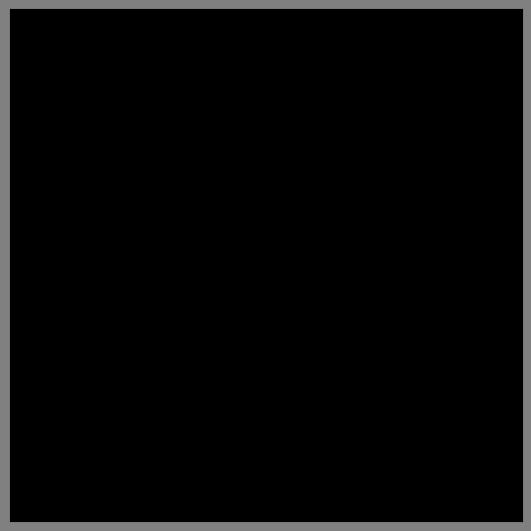

Render time: 1.000s (4.58% complete, 2520.2k rays)
Render time: 2.001s (23.86% complete, 10606.4k rays)
Render time: 3.003s (46.63% complete, 12529.6k rays)
Render time: 4.007s (68.62% complete, 12101.6k rays)
Render time: 5.008s (91.11% complete, 12373.9k rays)


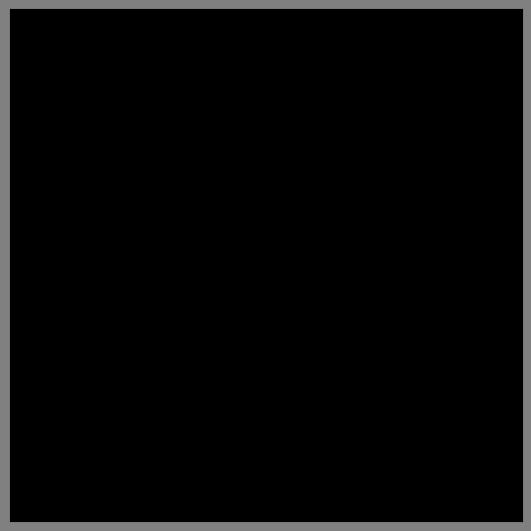

Render complete - time elapsed 5.442s - 10110.5k rays/s


In [76]:
camera = PinholeCamera((512, 512), parent=world, transform=translate(0, 4, -3.5) * rotate(0, -48, 0))
camera.spectral_bins = 15
camera.pixel_samples = 100

camera.observe()

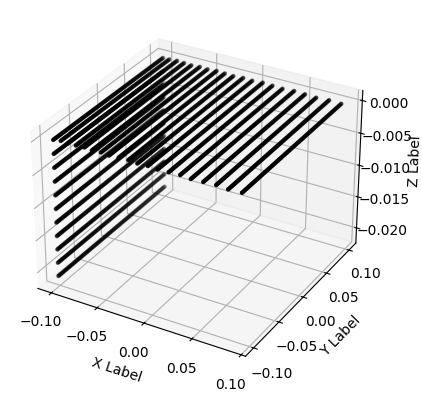

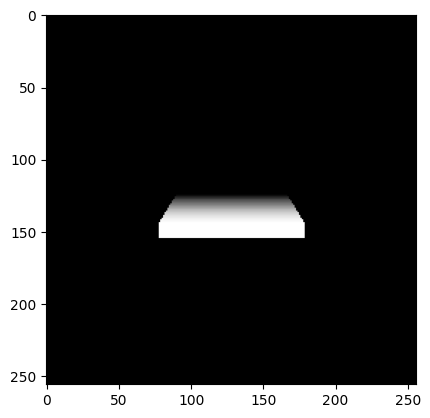

In [ ]:
# External imports
from os import path
from numpy import tan, pi as PI
import numpy as np
import matplotlib.pyplot as plt

# do not remove the following import or the 3D plotting will break
from mpl_toolkits.mplot3d import Axes3D

# Internal imports
from raysect.core.ray import Ray as CoreRay
from raysect.optical import World, translate, rotate, Point3D, d65_white, ConstantSF, Node, Vector3D
from raysect.optical.material.emitter import UniformVolumeEmitter
from raysect.optical.material import Lambert
from raysect.primitive import Box, Subtract
from raysect.primitive.mesh import Mesh
from raysect.optical.library import schott

world = World()

obj_filename = "rect_spherical_mirror.obj"
mesh = import_obj(obj_filename, parent=world)
mesh.bounding_box

# mesh_path = path.join(path.dirname(__file__), "../resources/stanford_bunny.rsm")
# mesh = Mesh.from_file(mesh_path, parent=world, transform=rotate(180, 0, 0))

# LIGHT BOX
padding = 1e-5
enclosure_thickness = 0.001 + padding
glass_thickness = 0.003

light_box = Node(parent=world)

enclosure_outer = Box(Point3D(-0.10 - enclosure_thickness, -0.02 - enclosure_thickness, -0.10 - enclosure_thickness),
                      Point3D(0.10 + enclosure_thickness, 0.0, 0.10 + enclosure_thickness))
enclosure_inner = Box(Point3D(-0.10 - padding, -0.02 - padding, -0.10 - padding),
                      Point3D(0.10 + padding, 0.001, 0.10 + padding))
enclosure = Subtract(enclosure_outer, enclosure_inner, material=Lambert(ConstantSF(0.2)), parent=light_box)

glass_outer = Box(Point3D(-0.10, -0.02, -0.10),
                  Point3D(0.10, 0.0, 0.10))
glass_inner = Box(Point3D(-0.10 + glass_thickness, -0.02 + glass_thickness, -0.10 + glass_thickness),
                  Point3D(0.10 - glass_thickness, 0.0 - glass_thickness, 0.10 - glass_thickness))
glass = Subtract(glass_outer, glass_inner, material=schott("N-BK7"), parent=light_box)

emitter = Box(Point3D(-0.10 + glass_thickness + padding, -0.02 + glass_thickness + padding, -0.10 + glass_thickness + padding),
              Point3D(0.10 - glass_thickness - padding, 0.0 - glass_thickness - padding, 0.10 - glass_thickness - padding),
              material=UniformVolumeEmitter(d65_white, 50), parent=light_box)

fov = 45
num_pixels = 256

# Launch rays using the same geometry calculations as a pinhole camera
image_width = 2 * tan(PI / 180 * 0.5 * fov)
image_delta = image_width / num_pixels

image_start_x = 0.5 * num_pixels * image_delta
image_start_y = 0.5 * num_pixels * image_delta

x_points = []
y_points = []
z_points = []
z_show = np.zeros((num_pixels, num_pixels))
for ix in range(num_pixels):
    for iy in range(num_pixels):

        # generate pixel transform
        pixel_x = image_start_x - image_delta * ix
        pixel_y = image_start_y - image_delta * iy

        # calculate point in virtual image plane to be used for ray direction
        origin = Point3D().transform(translate(0, 0.16, -0.7) * rotate(0, -12, 0))
        direction = Vector3D(pixel_x, pixel_y, 1).normalise().transform(translate(0, 0.16, -0.7) * rotate(0, -12, 0))

        intersection = world.hit(CoreRay(origin, direction))

        if intersection is not None:
            hit_point = intersection.hit_point.transform(intersection.primitive_to_world)
            x_points.append(hit_point.z)
            y_points.append(hit_point.x)
            z_points.append(hit_point.y)
            z_show[iy, ix] = hit_point.z
        else:
            # add small offset so background is black
            z_show[iy, ix] = 0.1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_points, y_points, z_points, c='k', marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.figure()
plt.imshow(z_show, cmap=plt.cm.Greys)

plt.show()